# <span style="color:orange"> Time Series - RNN(LSTM) based Temperature Prediction </span>

### <span style="color:orange"> Machine-Learning-Based Temperature Forecast for Temperature Adjustment in Runway Length Selection </span>

### <span style="color:orange"> - Recurrent Neural Network (LSTM) </span>

## by Susan Das


# 1. Install & Import Required Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# 2. Import Data


### Read “City_Temperature.csv” File and Imported into "df" DataFrame


In [ ]:
df = pd.read_csv("City_Temperature.csv")
df.head()

,Month,Day,Year,Date,Average Temp
0,1,1,1995,Jan-95,63.0
1,1,2,1995,Jan-95,61.4
2,1,3,1995,Jan-95,60.6
3,1,4,1995,Jan-95,61.3
4,1,5,1995,Jan-95,62.3


In [ ]:
df_temp = df[["Average Temp"]]
df_temp.head()

,Average Temp
0,63.0
1,61.4
2,60.6
3,61.3
4,62.3


# 3. EDA


### Finding Basic Statistics of the Temp Data


In [ ]:
df_temp.describe(include="all").transpose()

,count,mean,std,min,25%,50%,75%,max
Average Temp,9265.0,79.661511,7.986788,52.9,74.1,82.3,85.5,96.8


### Convert Average Daily Temperature Dataset into Monthly Maximum Temparature


In [ ]:
df_max = df.groupby(["Year", "Month"])["Average Temp"].max()
df_max = df_max.reset_index()
df_max["Date"] = pd.to_datetime(
    df_max.Year.astype(str) + "/" + df_max.Month.astype(str) + "/01"
)
df_max_mnth = df_max.set_index("Date")
df_max_mnth = df_max_mnth[["Average Temp"]]
df_max_mnth = df_max_mnth.rename(columns={"Average Temp": "Max Temp"})
df_max_mnth.head()

,Max Temp
Date,
1995-01-01,68.2
1995-02-01,79.7
1995-03-01,87.8
1995-04-01,92.1
1995-05-01,92.0


### Plot Maximum Monthly Temperature


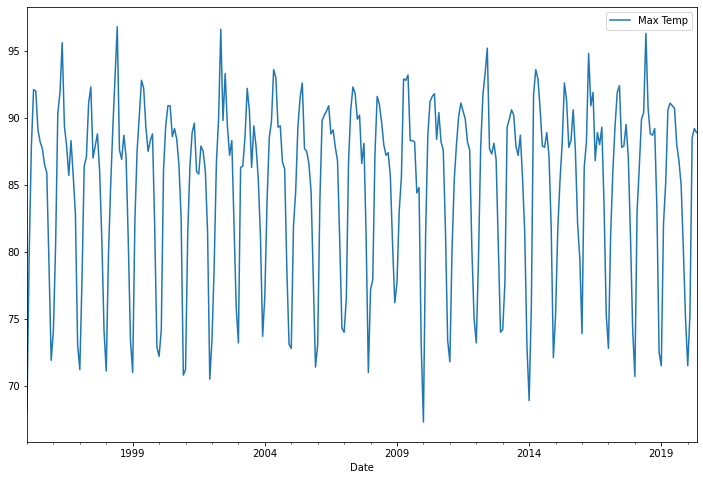

In [ ]:
df_max_mnth.plot(figsize=(12, 8))

### Finding Whether any Trend Exists in this Historical Temp Data


In [ ]:
x = np.arange(df_max_mnth["Max Temp"].size)
fit = np.polyfit(x, df_max_mnth["Max Temp"], deg=1)
print("Slope : " + str(fit[0]))
print("Intercept : " + str(fit[1]))

Slope : 0.002213241638329295
Intercept : 84.69768563162968


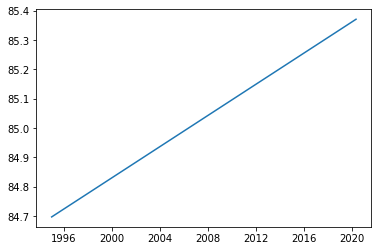

In [ ]:
fit_function = np.poly1d(fit)

plt.plot(df_max_mnth.index, fit_function(x))

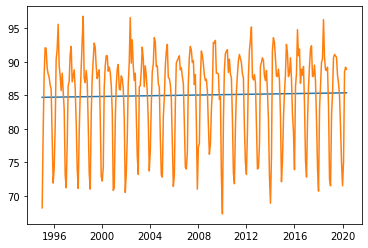

In [ ]:
plt.plot(df_max_mnth.index, fit_function(x))
plt.plot(df_max_mnth.index, df_max_mnth["Max Temp"])

plt.show()

# 4. Predictive Modelling to Forecast Next 24 Months Monthly Maximum Temperature


### Train Test Split


In [ ]:
len(df_max_mnth)

305

In [ ]:
len(df_max_mnth) - 30

275

In [ ]:
test_size = 30

In [ ]:
test_ind = len(df_max_mnth) - test_size

In [ ]:
train = df_max_mnth.iloc[:test_ind]
test = df_max_mnth[test_ind:]

In [ ]:
train

,Max Temp
Date,
1995-01-01,68.2
1995-02-01,79.7
1995-03-01,87.8
1995-04-01,92.1
1995-05-01,92.0
...,...
2017-07-01,87.8
2017-08-01,87.9
2017-09-01,89.5


In [ ]:
test

,Max Temp
Date,
2017-12-01,74.2
2018-01-01,70.7
2018-02-01,83.0
2018-03-01,86.3
2018-04-01,89.9
2018-05-01,90.4
2018-06-01,96.3
2018-07-01,90.7
2018-08-01,88.8


### Scaling


In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Create Time Series Generator


In [ ]:
length = 24
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [ ]:
X, y = generator[0]
print(f"Given the Array: \n{X.flatten()}")
print(f"Predict this y: \n {y}")

Given the Array: 
[0.03050847 0.42033898 0.69491525 0.84067797 0.83728814 0.73898305
 0.70847458 0.69152542 0.65084746 0.63050847 0.4        0.1559322
 0.23050847 0.4440678  0.77966102 0.83389831 0.95932203 0.74915254
 0.69830508 0.62372881 0.71186441 0.62372881 0.52542373 0.19661017]
Predict this y: 
 [[0.13220339]]


# 5. Modelling


In [ ]:
n_features = 1
model = Sequential()
model.add(LSTM(100, activation="relu", input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor="val_loss", patience=10)

In [ ]:
validation_generator = TimeseriesGenerator(
    scaled_test, scaled_test, length=length, batch_size=1
)

In [ ]:
model.fit_generator(
    generator, epochs=30, validation_data=validation_generator, callbacks=[early_stop]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
251/251 [==============================] - 5s 13ms/step - loss: 0.0728 - val_loss: 0.1011
Epoch 2/30
251/251 [==============================] - 3s 12ms/step - loss: 0.0525 - val_loss: 0.0720
Epoch 3/30
251/251 [==============================] - 3s 12ms/step - loss: 0.0406 - val_loss: 0.0628
Epoch 4/30
251/251 [==============================] - 3s 12ms/step - loss: 0.0317 - val_loss: 0.0383
Epoch 5/30
251/251 [==============================] - 3s 11ms/step - loss: 0.0160 - val_loss: 0.0251
Epoch 6/30
251/251 [==============================] - 3s 10ms/step - loss: 0.0133 - val_loss: 0.0170
Epoch 7/30
251/251 [==============================] - 3s 10ms/step - loss: 0.0117 - val_loss: 0.0236
Epoch 8/30
251/251 [==============================] - 3s 11ms/step - loss: 0.0097 - val_loss: 0.0162
Epoch 9/30
251/251 [==============================] - 3s 12ms/step - loss: 0.0082 - val_loss: 0.0198
Epoch 10/30
251/251 [==============================] - 3s 13ms/step - loss: 0.0073 - val_lo

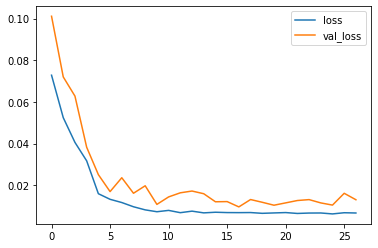

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### Evaluate on Test Data


In [ ]:
first_eval_batch = scaled_train[-length:]

In [ ]:
n_input = 24
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(first_eval_batch)

array([[0.39131376]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.23389831])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

### Inverse Transformation and Compare


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test["Predictions"] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,Max Temp,Predictions
Date,,
2017-12-01,74.2,78.843756
2018-01-01,70.7,79.933795
2018-02-01,83.0,85.657496
2018-03-01,86.3,89.304948
2018-04-01,89.9,91.616507
2018-05-01,90.4,91.466289
2018-06-01,96.3,90.760309
2018-07-01,90.7,89.113359
2018-08-01,88.8,88.886242


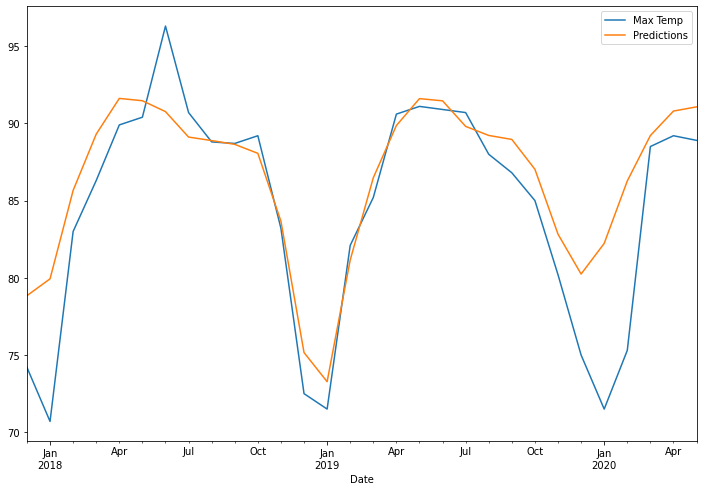

In [ ]:
test.plot(figsize=(12, 8))

### Retrain and Forecasting


In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df_max_mnth)

In [ ]:
length = 24  # Length of the output sequences
generator = TimeseriesGenerator(
    scaled_full_data, scaled_full_data, length=length, batch_size=1
)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation="relu", input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.fit_generator(
    generator, epochs=50, validation_data=validation_generator, callbacks=[early_stop]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
281/281 [==============================] - 5s 12ms/step - loss: 0.0735 - val_loss: 0.0730
Epoch 2/50
281/281 [==============================] - 3s 12ms/step - loss: 0.0531 - val_loss: 0.0933
Epoch 3/50
281/281 [==============================] - 3s 12ms/step - loss: 0.0489 - val_loss: 0.0577
Epoch 4/50
281/281 [==============================] - 3s 12ms/step - loss: 0.0420 - val_loss: 0.0543
Epoch 5/50
281/281 [==============================] - 3s 12ms/step - loss: 0.0227 - val_loss: 0.0295
Epoch 6/50
281/281 [==============================] - 3s 10ms/step - loss: 0.0135 - val_loss: 0.0290
Epoch 7/50
281/281 [==============================] - 3s 11ms/step - loss: 0.0099 - val_loss: 0.0241
Epoch 8/50
281/281 [==============================] - 3s 11ms/step - loss: 0.0080 - val_loss: 0.0123
Epoch 9/50
281/281 [==============================] - 3s 11ms/step - loss: 0.0090 - val_loss: 0.0327
Epoch 10/50
281/281 [==============================] - 3s 12ms/step - loss: 0.0086 - val_lo

### Calculate RMSE Score :


In [ ]:
print(
    f"RMSE Score : {np.sqrt(mean_squared_error(test['Max Temp'],test['Predictions']))}"
)

In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
df_max_mnth

,Max Temp
Date,
1995-01-01,68.2
1995-02-01,79.7
1995-03-01,87.8
1995-04-01,92.1
1995-05-01,92.0
...,...
2020-01-01,71.5
2020-02-01,75.3
2020-03-01,88.5


In [ ]:
forecast_index = pd.date_range(start="2020-06-01", periods=periods, freq="MS")

In [ ]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=["Forecast"])

In [ ]:
forecast_df

,Forecast
2020-06-01,89.495893
2020-07-01,88.130227
2020-08-01,87.166066
2020-09-01,86.724486
2020-10-01,85.709493
2020-11-01,81.261696
2020-12-01,73.738358
2021-01-01,71.688326
2021-02-01,79.829443
2021-03-01,84.645631


In [ ]:
forecast_df.to_csv(
    "24 Months Max Temp Predictions_Kolkata.csv", header=True, index=True
)

In [ ]:
df_max_mnth.tail(24)

,Max Temp
Date,
2018-06-01,96.3
2018-07-01,90.7
2018-08-01,88.8
2018-09-01,88.7
2018-10-01,89.2
2018-11-01,83.2
2018-12-01,72.5
2019-01-01,71.5
2019-02-01,82.1


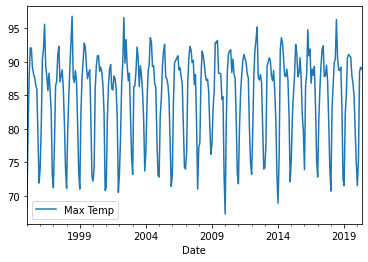

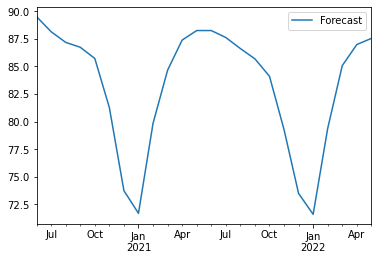

In [ ]:
df_max_mnth.plot()
forecast_df.plot()

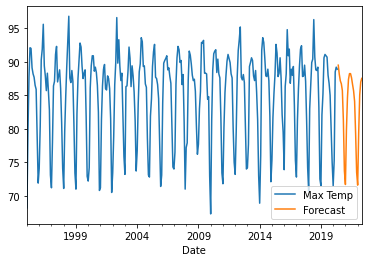

In [ ]:
ax = df_max_mnth.plot()
forecast_df.plot(ax=ax)

(576.0, 628.0)

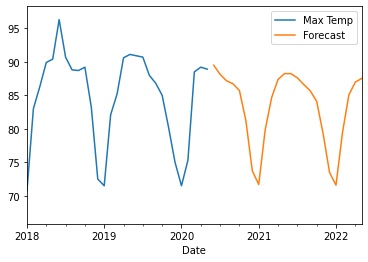

In [ ]:
ax = df_max_mnth.plot()
forecast_df.plot(ax=ax)
plt.xlim("2018-01-01", "2022-05-01")